In [ ]:
# pip install nltk
# pip install vaderSentiment
# pip install gensim
# pip install wordcloud
# pip install pyldavis

# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

# !python -m spacy download en_core_web_sm

# import libraries

In [25]:
# eda
import pandas as pd
import numpy as np
from collections import Counter

# data handling
import pyspark 
from pyspark.sql.functions import countDistinct

# nlp
import nltk
import spacy
import re

from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem.wordnet import WordNetLemmatizer

# topic modeling
import gensim
import pyLDAvis.gensim_models 
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import LdaModel
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# misc
from pprint import pprint

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# instantiate PySpark SparkSession and import JSON files

In [2]:
spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [3]:
df = spark.read.json('../01_data_collection/*.json')

In [4]:
df.printSchema()

root
 |-- contributors: string (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- coordinates: array (nullable = true)
 |    |    |-- element: double (containsNull = true)
 |    |-- type: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- display_text_range: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- media: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- display_url: string (nullable = true)
 |    |    |    |-- expanded_url: string (nullable = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- id_str: string (nullable = true)
 |    |    |    |

In [5]:
df.createOrReplaceTempView('df')

# perform basic SQL queries of data

In [6]:
# return count of all tweets
total_tweets = spark.sql('''
                                SELECT
                                    id_str as tweet_unique_id
                                FROM
                                    df
                                                            ''')

total_tweets.select(countDistinct('tweet_unique_id')).show()

+-------------------------------+
|count(DISTINCT tweet_unique_id)|
+-------------------------------+
|                         914364|
+-------------------------------+



In [8]:
# return count of unique twitter users:
unique_users = spark.sql('''
                                SELECT
                                    user.id_str as user_unique_id
                                FROM
                                    df
                                                             ''')

unique_users.select(countDistinct('user_unique_id')).show()

+------------------------------+
|count(DISTINCT user_unique_id)|
+------------------------------+
|                        452084|
+------------------------------+



In [9]:
# return count of unique tweets (not including retweets):
unique_tweets = spark.sql('''
                                SELECT
                                    id_str as tweet_unique_id
                                FROM
                                    df
                                WHERE 
                                    retweeted_status IS NULL
                                                                    ''')

unique_tweets.select(countDistinct('tweet_unique_id')).show()

+-------------------------------+
|count(DISTINCT tweet_unique_id)|
+-------------------------------+
|                         250507|
+-------------------------------+



# deeper dive with SQL queries

In [ ]:
# # tweet user metadata
# user = spark.sql('''
#                     SELECT 
#                         id_str as original_tweet_unique_id,
#                         user.id_str as user_id,
#                         user.screen_name as user_twitter_handle,
#                         user.description as user_description,
#                         user.name as user_display_name,
#                         user.location as user_location,
#                         user.followers_count as user_followers_count,
#                         user.friends_count as user_friends_count,
#                         user.statuses_count as user_tweets_count
#                     FROM 
#                         df
#                             ''')

In [ ]:
# # retweeted user metadata
# retweeted = spark.sql('''
#                         SELECT
#                             id_str as original_tweet_unique_id,
#                             retweeted_status as retweet_metadata,
#                             retweeted_status.full_text as retweeted_tweet_text,
#                             retweeted_status.id_str as retweeted_unique_id,
#                             retweeted_status.user.id_str as retweeted_user_id,
#                             retweeted_status.user.screen_name as retweeted_user_twitter_handle,
#                             retweeted_status.user.name as retweeted_user_display_name,
#                             retweeted_status.user.location as retweeted_user_location,
#                             retweeted_status.user.followers_count as retweeted_user_followers_count,
#                             retweeted_status.user.friends_count as retweeeted_user_friends_count,
#                             retweeted_status.user.statuses_count as retweeted_user_tweets_count
#                         FROM
#                             (SELECT *
#                              FROM df
#                              WHERE retweeted_status IS NOT NULL) as retweeted_subquery
#                                                                                         ''')

In [ ]:
# # quoted tweet user metadata
# quoted = spark.sql('''
#                     SELECT
#                         id_str as original_tweet_unique_id,
#                         is_quote_status as quoted_tweet,
#                         quoted_status as quoted_tweet_metadata,
#                         quoted_status.id_str as quoted_tweet_unique_id,
#                         quoted_status.user.id_str as quoted_tweet_user_id,
#                         quoted_status.user.screen_name as quoted_user_twitter_handle,
#                         quoted_status.user.name as quoted_user_display_name,
#                         quoted_status.user.location as quoted_user_location,
#                         quoted_status.user.followers_count as quoted_user_followers_count,
#                         quoted_status.user.friends_count as quoted_user_friends_count,
#                         quoted_status.user.statuses_count as quoted_user_tweets_count
#                     FROM
#                         (SELECT * 
#                          FROM df
#                          WHERE quoted_status IS NOT NULL) as quoted_subquery
#                                                                                 ''')

In [10]:
# check tweet relevancy for climate change
sample_climate_tweets = spark.sql('''
                                    SELECT 
                                        full_text as tweet_text
                                    FROM
                                        df
                                     WHERE
                                         full_text like '%climate change%'
                                                                            ''').take(10)

sample_climate_tweets

[Row(tweet_text="@WhiteHouse When properties are not being built &amp; bought by those in power/those advocating climate change in areas in which climate change is going to have a devastating impact then I'll believe in climate change\n They stop driving &amp; holidaying &amp; consuming energy for mansions I will believe"),
 Row(tweet_text='RT @nuelleduterte: My takeaway — he didn’t understand what his climate change speech at the UNGA was all about, if he can say these things.…'),
 Row(tweet_text='RT @PRGuy17: @DanielAndrewsMP Hey world, listen up! This is how you tackle climate change. Follow Victoria!'),
 Row(tweet_text='RT @ECOWARRIORSS: The media are astounded because they have never taken climate change seriously and support and prioritize the politicians…'),
 Row(tweet_text='@RBReich How many Americans are employed by the Bezos boner? Your beloved president just promised $11B in foreign climate change spending. Seems like helping Jackson MS with their municipal water system woul

In [11]:
# check tweet relevancy for global warming
sample_global_tweets = spark.sql('''
                                    SELECT 
                                        full_text as tweet_text
                                    FROM
                                        df
                                     WHERE
                                         full_text like '%global warming%'
                                                                        ''').take(10)

sample_global_tweets

[Row(tweet_text='It appears that Reiner has broken away from CIC and is creating the ICIC (International Crimes Investigative Committee) broadening the scope to look at parts of the Great RESET, including the Ukraine Crisis, global warming, breakdown of supply chains etc.\n\nhttps://t.co/fsclYMKtLQ'),
 Row(tweet_text='RT @RunRun94025061: Tämä on faktaa:\nKouluissa on opetettu että global warming ylikorostuu pohjoisessa.\nVuosikymmeniä on kulunut, mikään ei…'),
 Row(tweet_text='@johnredwood So sagely true (SI).  If you wasters had actually got your fingers out just once in the last 12 years we might have stood a chance AND helped global warming.'),
 Row(tweet_text="Like the world won't end by global warming flood drought or zombies it'll end bc of k-pop stans"),
 Row(tweet_text="RT @craftmeistercs: If global warming isn't real wtf is this?? https://t.co/adOkioasxg"),
 Row(tweet_text='@rholland02 @PaulMitchell_AB And when you’re producing more CO2 than you have trees and other carbon sin

In [12]:
# check tweet relevancy for climate deniers
sample_denier_tweets = spark.sql('''
                                    SELECT 
                                        full_text as tweet_text
                                    FROM
                                        df
                                     WHERE
                                         full_text like '%climate deniers%'
                                                                        ''').take(10)

sample_denier_tweets

[Row(tweet_text="@PeterSweden7 If we're dealing in generalisations, all climate deniers are either cranks or fossil fuel propagandists"),
 Row(tweet_text='@leadingdems You know you can change all that. All us ‘climate deniers’ are just waiting for real scientific proof CO2 can alter the climate. When you find that proof we will be all on board. We just have a hard time changing the world based on unproven science.'),
 Row(tweet_text='@PGDynes Italy had a historic drought and now they elect climate deniers.'),
 Row(tweet_text='@bithits I have a copy of a voluminous study that was done by the National Ocean and Air group that pointedly shuts down climate deniers (2020). It gives historical references as well as what will/has started to happen. It’s not just weather.'),
 Row(tweet_text='..so many of the bad politicians are like that, flying in the Climate Emergency - anyone flying to climate conferences &amp; meetings or any meeting are not climate leaders - they are climate deniers, dela

In [13]:
# most retweeted
most_retweeted = spark.sql('''
                                SELECT
                                    user.screen_name as user_twitter_handle,
                                    full_text as tweet_text,
                                    SUM(retweet_count) as total_retweets
                                FROM
                                    df
                                WHERE
                                    retweeted_status IS NULL
                                GROUP BY
                                    user_twitter_handle,
                                    tweet_text
                                ORDER BY
                                    total_retweets DESC
                                LIMIT 20
                                                        ''')

most_retweeted.show()

+-------------------+--------------------+--------------+
|user_twitter_handle|          tweet_text|total_retweets|
+-------------------+--------------------+--------------+
|    OccupyDemocrats|Trumpers keep cla...|         14820|
|          DanRather|Now IS the time t...|          8822|
|      Andrew_Adonis|2 huge stories to...|          8203|
|         disclosetv|NEW - UN Secretar...|          7815|
|         __Pfeiffer|This is amazing. ...|          7234|
|           emmagmay|You know who isn’...|          7089|
|       bennyjohnson|Hurricanes in Ame...|          7088|
|         caslernoel|Yes, Ron DeSantis...|          6878|
|          Resist_05|United Nations, M...|          5999|
|    TallDarknJewish|Horrible news: @A...|          5812|
|     thomas_garrard|I’m wondering wha...|          5642|
|          nanditab1|So I was the only...|          5473|
|      AmoneyResists|Hurricane Ian too...|          5402|
|       NoLieWithBTC|A life-size sculp...|          4659|
|    backtolif

In [18]:
# users with most followers
most_followers = spark.sql('''
                                SELECT
                                    user.screen_name as user_twitter_handle,
                                    MAX(user.followers_count) as max_user_followers
                                FROM
                                    df
                                GROUP BY
                                    user_twitter_handle
                                ORDER BY
                                    max_user_followers DESC
                                LIMIT 20
                                                        ''')

most_followers.show()

+-------------------+------------------+
|user_twitter_handle|max_user_followers|
+-------------------+------------------+
|                CNN|          60056238|
|            nytimes|          54452124|
|             NatGeo|          28255303|
|       TheEconomist|          27017865|
|              POTUS|          25984977|
|            Reuters|          25551388|
|            FoxNews|          22441509|
|                WSJ|          20219386|
|     washingtonpost|          19903087|
|        LeoDiCaprio|          19644219|
|               TIME|          19372175|
|          BJP4India|          19229271|
|             aajtak|          18813473|
|             Forbes|          18381616|
|                ABC|          17725930|
|               ndtv|          17499989|
|         karanjohar|          17262570|
|                 AP|          16051493|
|                 UN|          15965558|
|      BernieSanders|          15726585|
+-------------------+------------------+



In [19]:
# most_user_mentions
user_mentions = spark.sql('''
                            SELECT
                                entities.user_mentions.screen_name as tweet_mentioned_user_twitter_handle
                            FROM
                                df
                                    ''')

user_mentions.show(20)

+-----------------------------------+
|tweet_mentioned_user_twitter_handle|
+-----------------------------------+
|                       [WhiteHouse]|
|                    [nuelleduterte]|
|               [FortescueFuture,...|
|                     [VictoriaQOTD]|
|                    [MrMatthewTodd]|
|                                 []|
|               [PRGuy17, DanielA...|
|               [TNInstitute, ros...|
|                      [Ed_Miliband]|
|                        [kdnerak33]|
|                     [CCactus_NFTs]|
|                   [WildlifeTrusts]|
|                                 []|
|                     [ECOWARRIORSS]|
|                      [NusretAnjum]|
|                          [RBReich]|
|                      [AbiluTangwa]|
|                    [CraigBennett3]|
|                     [CCactus_NFTs]|
|                                 []|
+-----------------------------------+
only showing top 20 rows



In [21]:
user_mentions_list = []
for mentions in user_mentions.collect():
    for obj in mentions['tweet_mentioned_user_twitter_handle']:
        user_mentions_list.append(obj)

In [22]:
user_mentions_list[0:10]

['WhiteHouse',
 'nuelleduterte',
 'FortescueFuture',
 'UN',
 'VictoriaQOTD',
 'MrMatthewTodd',
 'PRGuy17',
 'DanielAndrewsMP',
 'TNInstitute',
 'rosaluxglobal']

In [23]:
len(user_mentions_list)

1124769

In [26]:
most_common_mentions = Counter(user_mentions_list).most_common(20)
most_common_mentions

[('OccupyDemocrats', 13888),
 ('PeterDClack', 13099),
 ('ClimateHuman', 12471),
 ('DanRather', 11083),
 ('caslernoel', 9318),
 ('Andrew_Adonis', 8883),
 ('AmoneyResists', 7939),
 ('__Pfeiffer', 7270),
 ('disclosetv', 7188),
 ('bennyjohnson', 7156),
 ('lavern_spicer', 6669),
 ('emmagmay', 6468),
 ('_theghettomonk', 6068),
 ('Resist_05', 5847),
 ('MikeHudema', 5714),
 ('nanditab1', 5546),
 ('JoshShapiroPA', 5215),
 ('benshapiro', 5165),
 ('thomas_garrard', 5148),
 ('Amtrak', 5148)]

In [27]:
most_user_mentions = pd.DataFrame(most_common_mentions, columns=[['user_name','mentions']])
most_user_mentions

,user_name,mentions
0,OccupyDemocrats,13888
1,PeterDClack,13099
2,ClimateHuman,12471
3,DanRather,11083
4,caslernoel,9318
5,Andrew_Adonis,8883
6,AmoneyResists,7939
7,__Pfeiffer,7270
8,disclosetv,7188
9,bennyjohnson,7156


In [28]:
# tweets from most common location
user_location = spark.sql('''
                            SELECT
                                user.location as user_location
                            FROM
                                df
                            WHERE 
                                retweeted_status.id_str IS NULL    
                                                                ''')

user_location.show(20)

+--------------------+
|       user_location|
+--------------------+
|               York |
|                    |
|     Berlin, Germany|
|             England|
|          Texas, USA|
|                    |
|                    |
|                 U K|
|Perth, Western Au...|
|                    |
|              London|
|               India|
|                    |
|           The Woods|
|      Nairobi, Kenya|
|she/her, they/the...|
|Rural Hall, North...|
|      Sulok ng kalye|
|                    |
|                    |
+--------------------+
only showing top 20 rows



In [29]:
user_location_list = []
for location in user_location.collect():
    user_location_list.append(location['user_location'])

In [30]:
user_location_list[0:10]

['York ',
 '',
 'Berlin, Germany',
 'England',
 'Texas, USA',
 '',
 '',
 'U K',
 'Perth, Western Australia',
 '']

In [31]:
most_common_locations = Counter(user_location_list).most_common(20)
most_common_locations

[('', 88646),
 ('United States', 3635),
 ('Canada', 1855),
 ('USA', 1781),
 ('London', 1734),
 ('London, England', 1459),
 ('Washington, DC', 1442),
 ('United Kingdom', 1017),
 ('Earth', 1006),
 ('Australia', 999),
 ('New York, NY', 986),
 ('UK', 980),
 ('Florida, USA', 965),
 ('Los Angeles, CA', 964),
 ('California, USA', 938),
 ('Nairobi, Kenya', 816),
 ('global', 727),
 ('Texas, USA', 696),
 ('India', 691),
 ("Your Motherboard's house", 635)]

In [32]:
most_user_locations = pd.DataFrame(most_common_locations, columns=[['location','count']])
most_user_locations

,location,count
0,,88646
1,United States,3635
2,Canada,1855
3,USA,1781
4,London,1734
5,"London, England",1459
6,"Washington, DC",1442
7,United Kingdom,1017
8,Earth,1006
9,Australia,999


In [33]:
# tweet metadata
tweets = spark.sql('''
                        SELECT
                            id_str as tweet_unique_id,
                            lang as tweet_lang,
                            full_text as tweet_text
                        FROM
                            df
                        WHERE 
                            retweeted_status.id_str IS NULL
                                                            ''')

tweets.show(5)

+-------------------+----------+--------------------+
|    tweet_unique_id|tweet_lang|          tweet_text|
+-------------------+----------+--------------------+
|1574300760367562753|        en|@WhiteHouse When ...|
|1574300742739009537|        en|We’re proud to sh...|
|1574300740385837058|        en|🗓️ 26 – 29 Septe...|
|1574300712523407360|        en|It appears that R...|
|1574300691538931712|        en|@RBReich How many...|
+-------------------+----------+--------------------+
only showing top 5 rows



In [34]:
tweets.count()

250507

In [35]:
tweets_df = tweets.toPandas()

In [36]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250507 entries, 0 to 250506
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tweet_unique_id  250507 non-null  object
 1   tweet_lang       250507 non-null  object
 2   tweet_text       250507 non-null  object
dtypes: object(3)
memory usage: 5.7+ MB


In [37]:
# check 'tweet_lang' unique count
tweets_df['tweet_lang'].nunique()

56

In [38]:
# show 'tweet_lang' values
tweets_df['tweet_lang'].unique()

array(['en', 'tl', 'und', 'th', 'fr', 'nl', 'de', 'in', 'ml', 'da', 'et',
       'ja', 'it', 'tr', 'es', 'ur', 'ne', 'hi', 'ko', 'te', 'cy', 'ta',
       'pl', 'ro', 'fi', 'mr', 'no', 'ca', 'el', 'pt', 'cs', 'ru', 'sv',
       'sd', 'zh', 'iw', 'vi', 'lv', 'ar', 'or', 'hu', 'sl', 'si', 'eu',
       'uk', 'pa', 'ps', 'ht', 'gu', 'is', 'kn', 'lt', 'bg', 'bn', 'fa',
       'sr'], dtype=object)

In [39]:
# remove 'tweet_lang' != 'en'
tweets_df = tweets_df[tweets_df['tweet_lang'] == 'en']

In [40]:
sample_tweets = tweets_df.copy()

In [41]:
sample_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236645 entries, 0 to 250506
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   tweet_unique_id  236645 non-null  object
 1   tweet_lang       236645 non-null  object
 2   tweet_text       236645 non-null  object
dtypes: object(3)
memory usage: 7.2+ MB


In [42]:
# tweet[0] before preprocessing for reference
sample_tweets['tweet_text'][0]

"@WhiteHouse When properties are not being built &amp; bought by those in power/those advocating climate change in areas in which climate change is going to have a devastating impact then I'll believe in climate change\n They stop driving &amp; holidaying &amp; consuming energy for mansions I will believe"

In [43]:
# remove urls
sample_tweets['converted_tweets'] = sample_tweets['tweet_text'].apply(lambda x: re.sub('htt\S+', '', x))


In [44]:
# remove punctuation and lowercase text
sample_tweets['converted_tweets'] = sample_tweets['converted_tweets'].apply(lambda x: re.sub('[^\w\s]', ' ', x)).str.lower()


In [45]:
# tweet[0] after preprocessing
sample_tweets['converted_tweets'][0]

' whitehouse when properties are not being built  amp  bought by those in power those advocating climate change in areas in which climate change is going to have a devastating impact then i ll believe in climate change\n they stop driving  amp  holidaying  amp  consuming energy for mansions i will believe'

In [46]:
# vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

In [47]:
# apply method to cleaned text, add new column
sample_tweets['score'] = sample_tweets['converted_tweets'].apply(analyzer.polarity_scores).apply(lambda x: x.get('compound'))


In [48]:
sample_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 236645 entries, 0 to 250506
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   tweet_unique_id   236645 non-null  object 
 1   tweet_lang        236645 non-null  object 
 2   tweet_text        236645 non-null  object 
 3   converted_tweets  236645 non-null  object 
 4   score             236645 non-null  float64
dtypes: float64(1), object(4)
memory usage: 18.9+ MB


In [49]:
sample_tweets['sentiment'] = sample_tweets['score'].apply(lambda x: 'Positive' if x > 0.0 else 'Negative' if x < 0.0 else 'Neutral')


In [50]:
sample_tweets.head()

,tweet_unique_id,tweet_lang,tweet_text,converted_tweets,score,sentiment
0,1574300760367562753,en,@WhiteHouse When properties are not being buil...,whitehouse when properties are not being buil...,-0.6597,Negative
1,1574300742739009537,en,We’re proud to share the launch of a free-acce...,we re proud to share the launch of a free acce...,0.8625,Positive
2,1574300740385837058,en,🗓️ 26 – 29 September 2022\n\nAlready have plan...,26 29 september 2022\n\nalready have plan...,0.8074,Positive
3,1574300712523407360,en,It appears that Reiner has broken away from CI...,it appears that reiner has broken away from ci...,-0.0772,Negative
4,1574300691538931712,en,@RBReich How many Americans are employed by th...,rbreich how many americans are employed by th...,0.9117,Positive


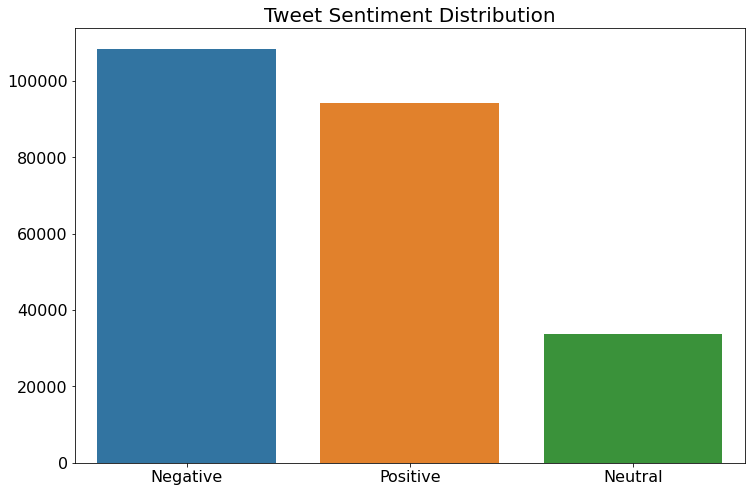

In [51]:
plt.figure(figsize = (12,8))
plt.title('Tweet Sentiment Distribution',fontsize = 20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

ax = sns.countplot(x=sample_tweets['sentiment'])
ax.set(xlabel=None)
ax.set(ylabel=None)

# plt.savefig('../04_data_visualizations/tweet_sentiment_distribution.png', transparent=True)

plt.show();

In [52]:
corpus = sample_tweets['tweet_text']
corpus[0]

"@WhiteHouse When properties are not being built &amp; bought by those in power/those advocating climate change in areas in which climate change is going to have a devastating impact then I'll believe in climate change\n They stop driving &amp; holidaying &amp; consuming energy for mansions I will believe"

In [54]:
# text preprocessing function using spaCy.lemma_ and spaCy.pos_
def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
    nlp = spacy.load('en_core_web_sm', disable=['parser','ner'])
    processed_texts = []
    for text in texts:
        doc = nlp(text)
        lemmatized_text = []
        for token in doc:
            if token.pos_ in allowed_postags:
                lemmatized_text.append(token.lemma_)
        final = ' '.join(lemmatized_text)
        processed_texts.append(final)
    return (processed_texts)

lemmatized_texts = lemmatization(corpus)
lemmatized_texts[0]

'property build buy power advocate climate change area climate change go devastating impact then believe climate change stop drive holidaying amp consume energy mansion believe'

In [91]:
# additional text preprocessing function using gensim.utils.simple_preprocess
def gen_words(texts):
    final = []
    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)
        final.append(new)
    return(final)

data_words = gen_words(lemmatized_texts)
data_words[0]

['property',
 'build',
 'buy',
 'power',
 'advocate',
 'climate',
 'change',
 'area',
 'climate',
 'change',
 'go',
 'devastating',
 'impact',
 'then',
 'believe',
 'climate',
 'change',
 'stop',
 'drive',
 'holidaying',
 'amp',
 'consume',
 'energy',
 'mansion',
 'believe']

In [92]:
sample = data_words[0]

In [93]:
sample

['property',
 'build',
 'buy',
 'power',
 'advocate',
 'climate',
 'change',
 'area',
 'climate',
 'change',
 'go',
 'devastating',
 'impact',
 'then',
 'believe',
 'climate',
 'change',
 'stop',
 'drive',
 'holidaying',
 'amp',
 'consume',
 'energy',
 'mansion',
 'believe']

In [95]:
exclude = ['http', 'https', 'co', 'com']

for words in data_words:
    for obj in exclude:
        if obj in words:
            words.remove(obj)

In [96]:
dictionary = Dictionary(data_words)

In [97]:
print('Number of documents:', len(corpus))
print('Number of unique words in initital documents:', len(dictionary))
# Filter out words that occur less than 1000 documents, or more than 25% of the documents.
dictionary.filter_extremes(no_below=1000, no_above=0.50)
print('Number of unique words after removing rare and common words:', len(dictionary))

Number of documents: 236645
Number of unique words in initital documents: 150755
Number of unique words after removing rare and common words: 543


In [98]:
# transform processed words into str for wordcloud
strings = []

for doc in data_words:
    for token in doc:
        strings.append(token)

words = ' '.join(strings)

In [99]:
stop_words = set(stopwords.words('english'))
stop_words.add('http')
stop_words.add('https')
stop_words.add('co')
stop_words.add('com')

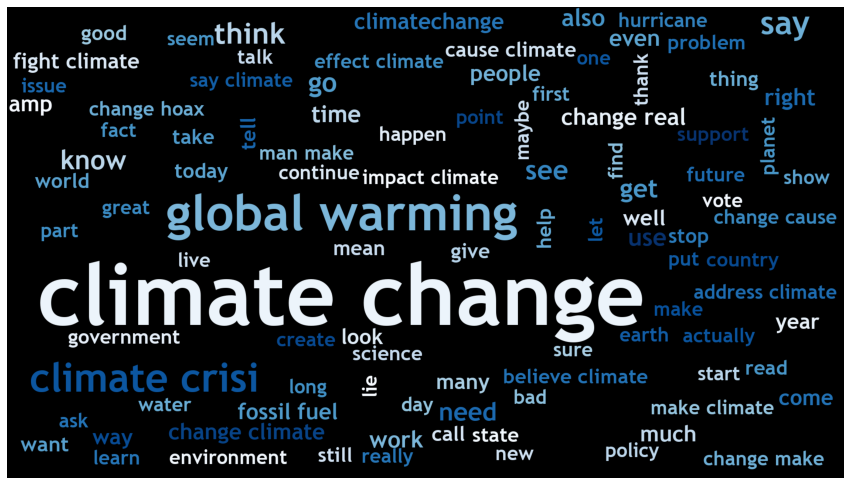

In [100]:
# create a wordcloud object
wordcloud = WordCloud(font_path='../05_misc/Trebuchet MS Bold.TTF', 
                      stopwords=stop_words, 
                      width=1920, height=1080, 
                      max_words=100, colormap='Blues')

wordcloud.generate(words)

plt.figure(figsize= (15,10))
plt.imshow(wordcloud)
plt.axis('off')
# plt.savefig('../04_data_visualizations/tweet_word_cloud.png')
plt.show();

In [101]:
id2word = dictionary

corpus = []
for text in data_words:
    new = id2word.doc2bow(text)
    corpus.append(new)

In [112]:
num_topics = 4

lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     random_state=42,
                     update_every=1,
                     chunksize=100,
                     passes=20,
                     alpha='auto')

In [113]:
pprint(lda_model.print_topics())

[(0,
  '0.058*"hurricane" + 0.047*"global" + 0.040*"warming" + 0.040*"more" + '
  '0.036*"people" + 0.033*"year" + 0.030*"make" + 0.028*"get" + 0.026*"storm" '
  '+ 0.025*"cause"'),
 (1,
  '0.045*"happen" + 0.045*"real" + 0.031*"thing" + 0.031*"way" + '
  '0.029*"science" + 0.029*"re" + 0.026*"good" + 0.024*"live" + 0.024*"event" '
  '+ 0.022*"fact"'),
 (2,
  '0.040*"crisis" + 0.033*"go" + 0.033*"say" + 0.031*"so" + 0.031*"just" + '
  '0.025*"time" + 0.024*"need" + 0.023*"think" + 0.021*"know" + 0.019*"talk"'),
 (3,
  '0.031*"believe" + 0.028*"weather" + 0.027*"only" + 0.027*"world" + '
  '0.025*"want" + 0.022*"come" + 0.021*"human" + 0.018*"also" + 0.017*"water" '
  '+ 0.016*"energy"')]


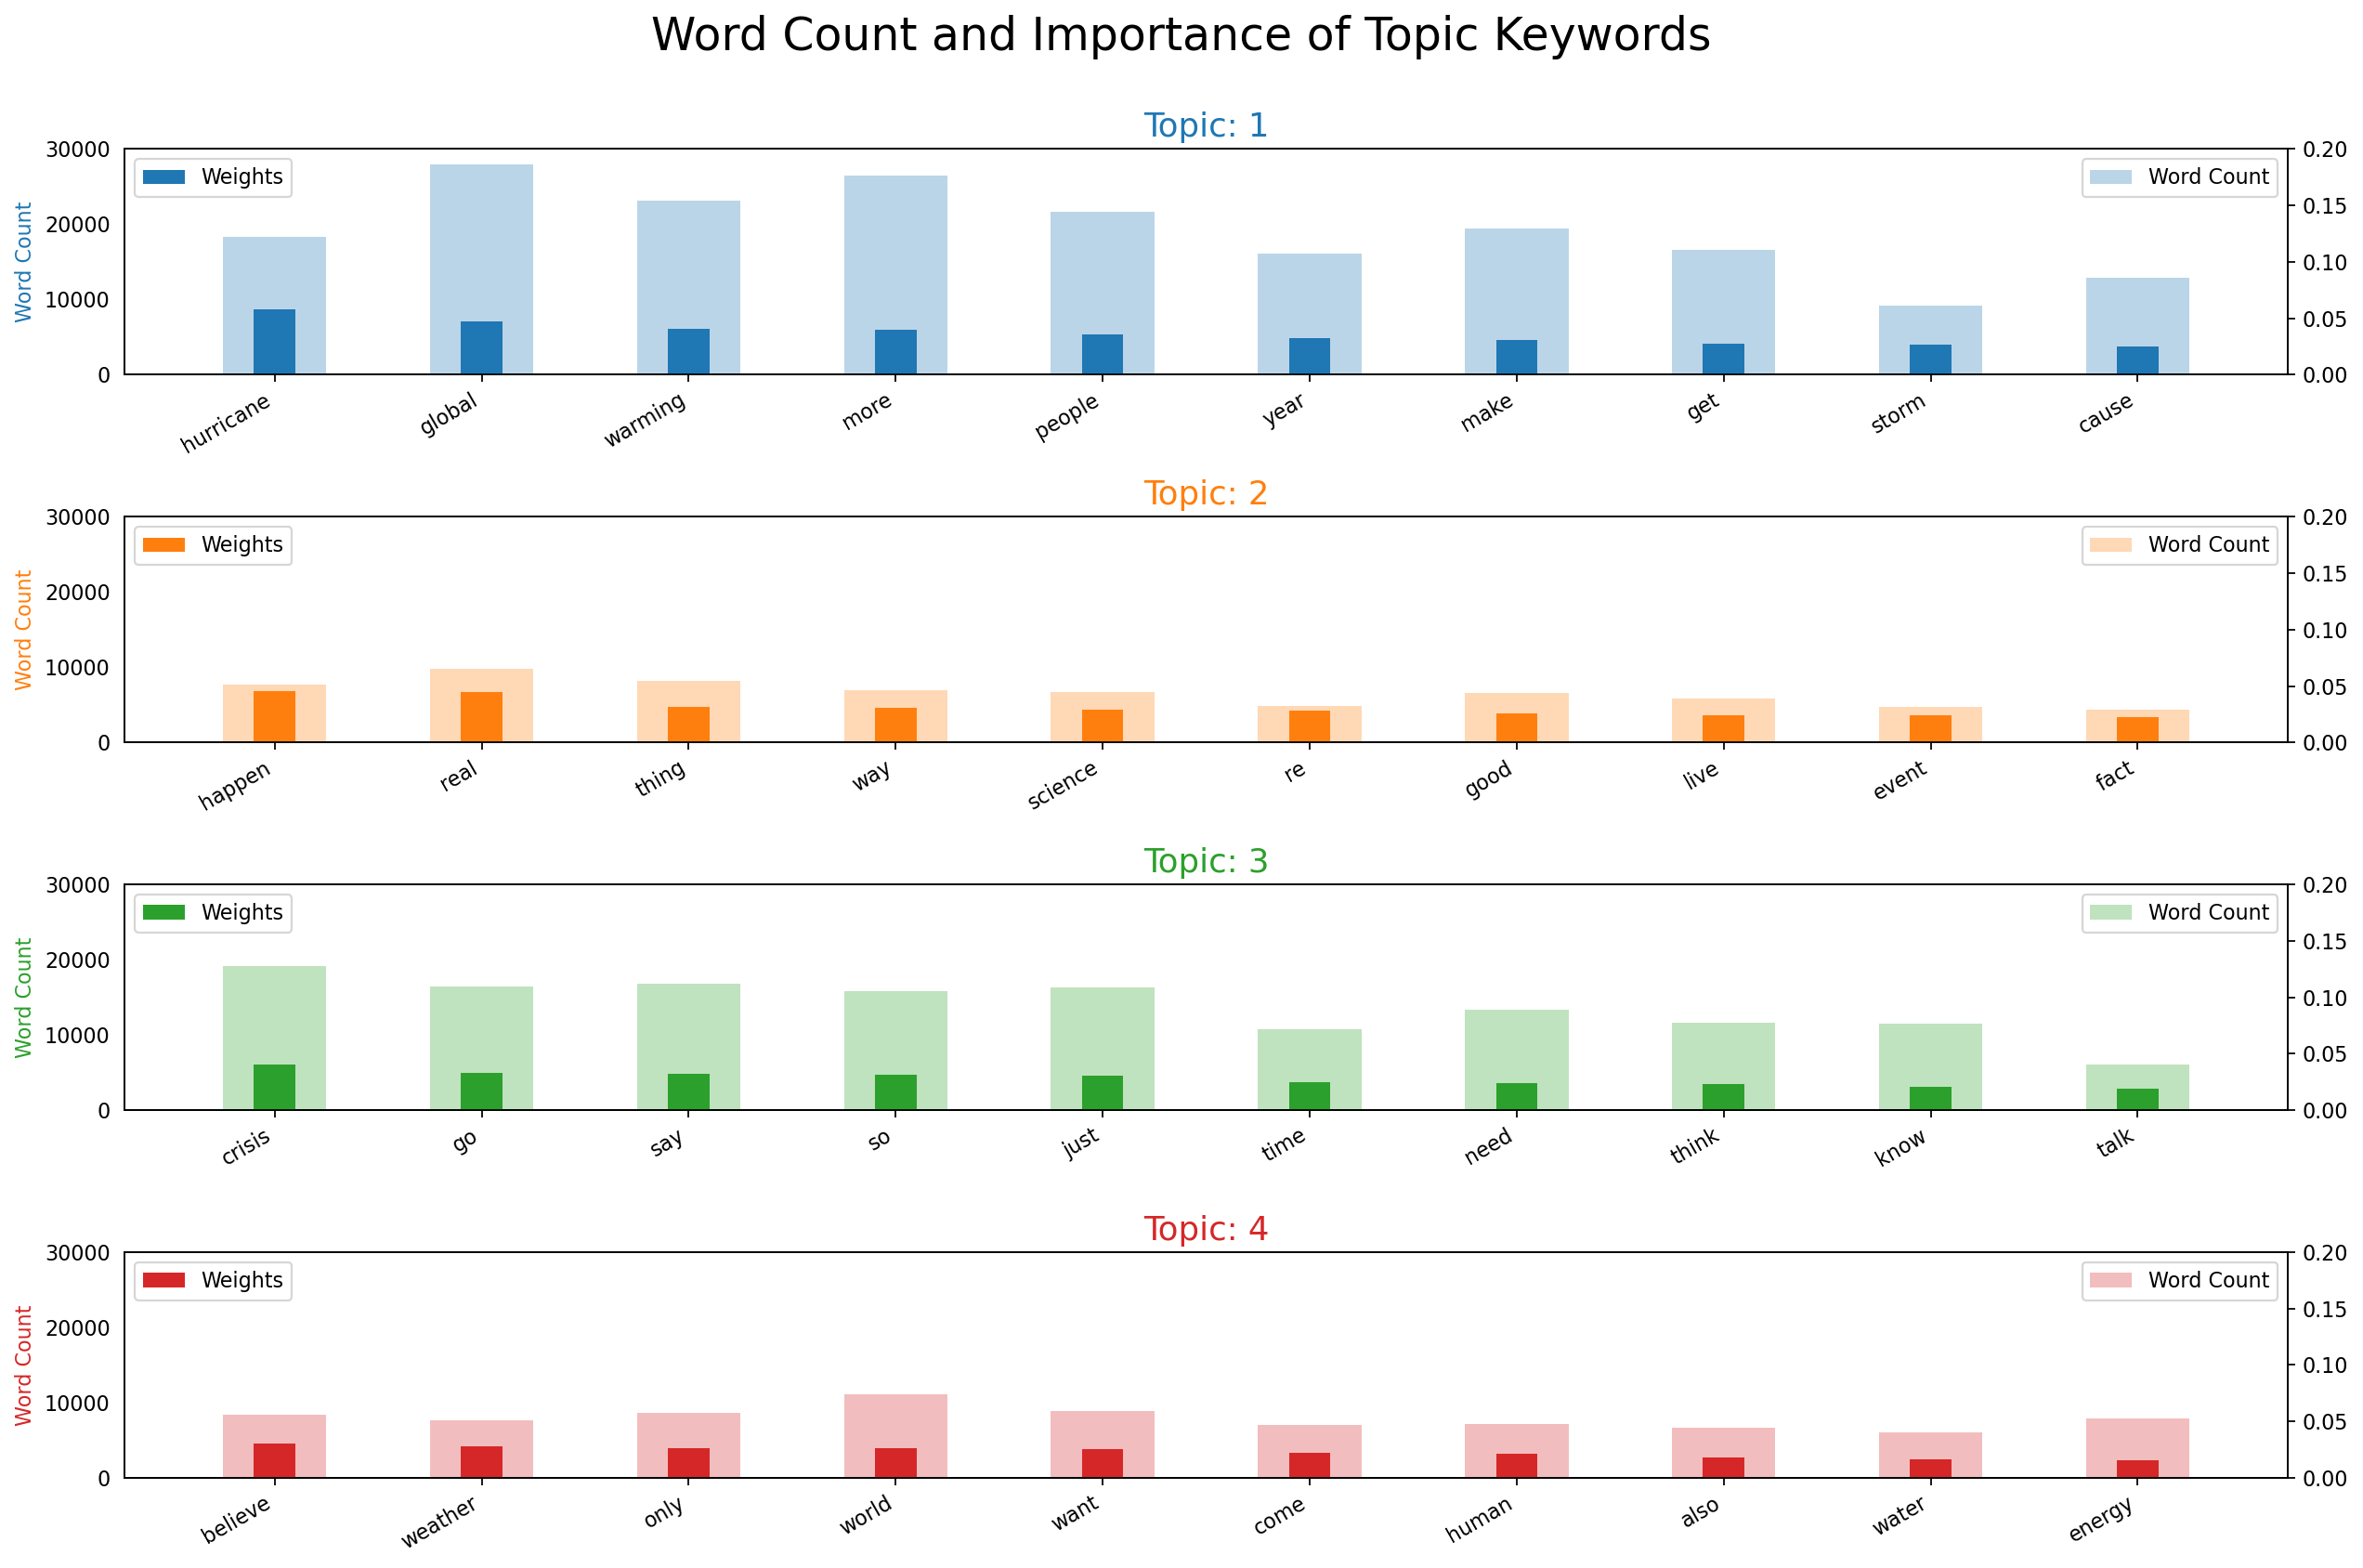

In [117]:
from collections import Counter
import matplotlib.colors as mcolors

topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.20); ax.set_ylim(0, 30000)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper right'); ax_twin.legend(loc='upper left')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)  
plt.savefig('../04_data_visualizations/tweet_keywords_by_topic.png', transparent=True)
plt.show();

In [115]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.358188  0.172680       1        1  34.919706
2      0.332715  0.216633       2        1  30.825677
3      0.025366 -0.403165       3        1  20.306665
1      0.000108  0.013851       4        1  13.947951, topic_info=          Term          Freq         Total Category  logprob  loglift
513  hurricane  35141.000000  35141.000000  Default  30.0000  30.0000
29      global  28498.000000  28498.000000  Default  29.0000  29.0000
33     warming  24318.000000  24318.000000  Default  28.0000  28.0000
58      crisis  21480.000000  21480.000000  Default  27.0000  27.0000
37        more  23903.000000  23903.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
396    history   2757.357835   2758.168257   Topic4  -4.4694   1.9695
239       hard   2661.787489   2662.606717   Topic4  -4.5047   1.9695
252     damage   2580.902234   2581.711760   Topic4  -4.5356   1.9695
330      guess   2557.504247   2558.318840   Topic4  -4.5447   1.9695
61       green   2474.410331   2475.220152   Topic4  -4.5777   1.9695

[150 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
59        4  0.999728    again
108       4  0.999716      all
50        3  0.999873     also
452       4  0.999791   always
0         3  0.999785      amp
...     ...       ...      ...
244       3  0.999895  weather
249       1  0.999916     well
93        4  0.999807     work
86        3  0.999912    world
71        1  0.999945     year

[120 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])